In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (ensure 'train.csv' is in your working directory)
data = pd.read_csv('train.csv')

# View the first few rows
print("Head of dataset:")
print(data.head())

# Basic info and statistics
print("\nDataset Info:")
print(data.info())

print("\nSummary Statistics:")
print(data.describe())

# Check missing values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Head of dataset:
   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns 

In [2]:
data.drop('salary', axis=1, inplace=True)

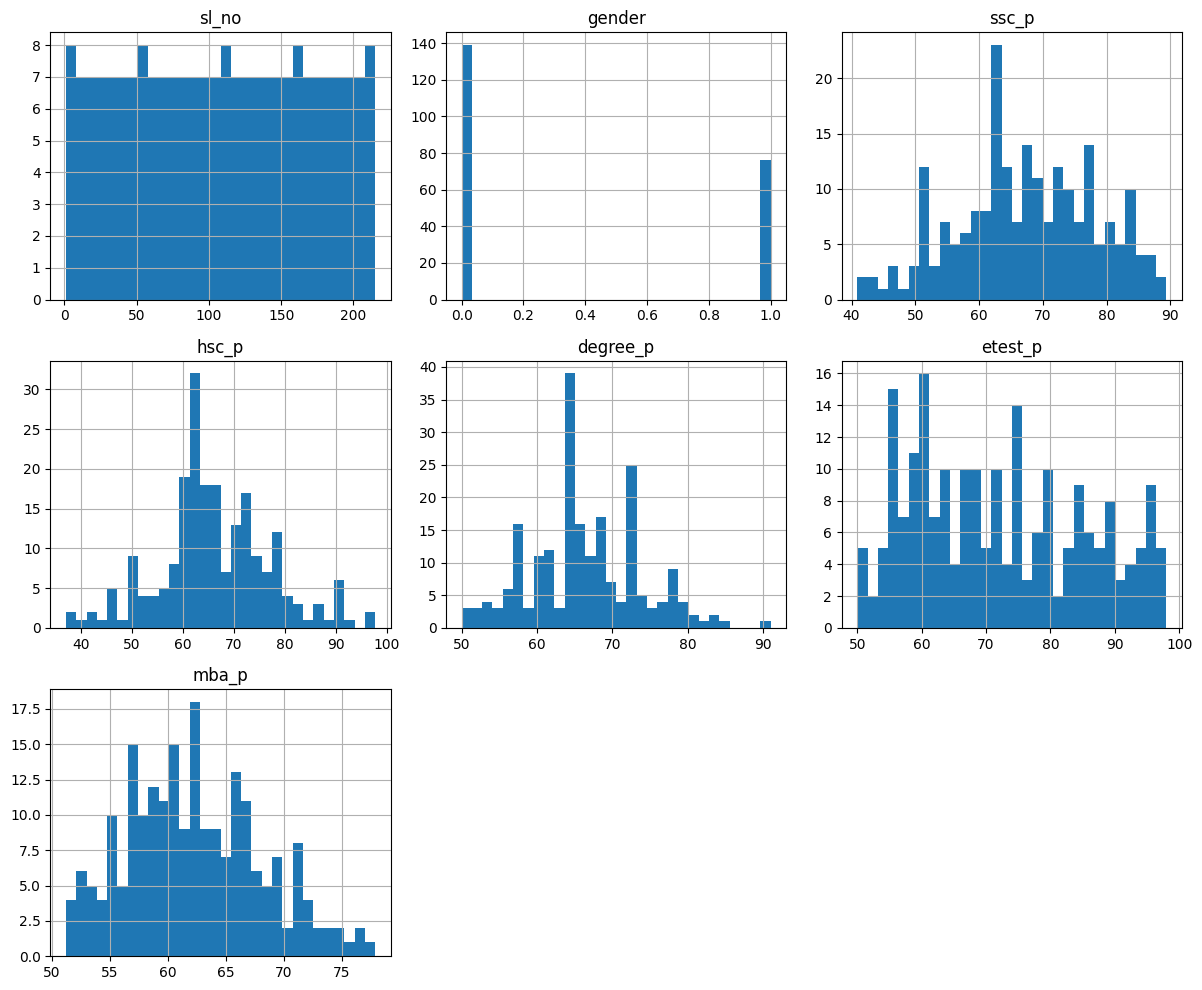

In [3]:
data.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

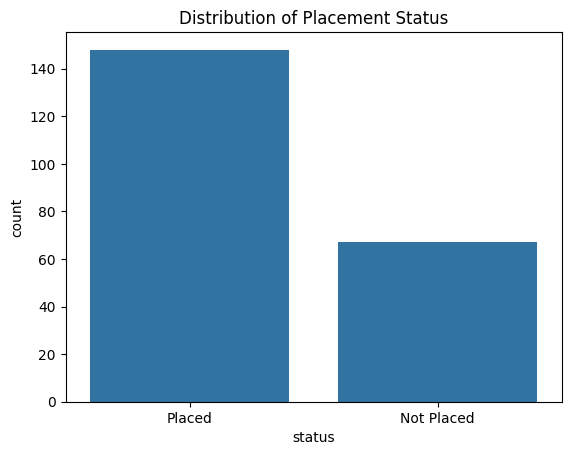

In [4]:
sns.countplot(x='status', data=data)
plt.title("Distribution of Placement Status")
plt.show()


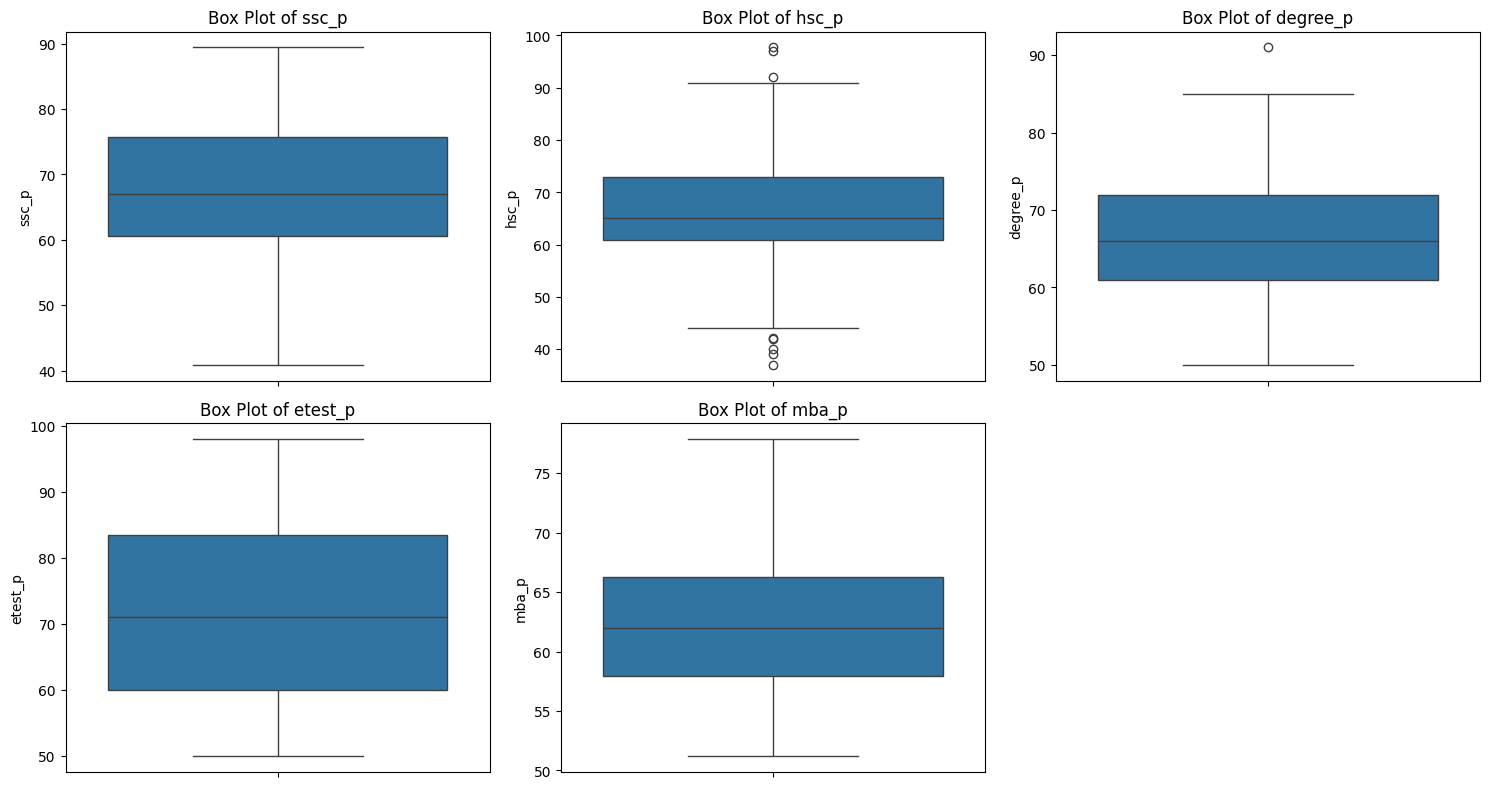

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns for which we want to generate box plots
numerical_columns = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Loop over each column and create a subplot with a box plot
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)  # Adjust rows/cols for layout (here, 2 rows and 3 columns)
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot of {col}")
    plt.ylabel(col)

plt.tight_layout()  # Adjust spacing so subplots do not overlap
plt.show()


In [5]:
#dropping the identifier
df = data.copy()
df.drop('sl_no', axis=1, inplace=True)

In [6]:
#encoding the target variable(status)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])
# For example, this may encode 'Placed' as 1 and 'Not Placed' as 0


In [7]:
#identify the categorical features
categorical_cols = ['ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation', 'gender']

#One-hote encoding using column transformer(pd.getDummies may leak data, which we don't want haha)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'  # Leave the numerical columns unchanged
)

# Fit and transform the data; note that the result is a NumPy array.
df_transformed = ct.fit_transform(df)

# Get feature names for the encoded columns
encoded_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(categorical_cols)
non_transformed_cols = [col for col in df.columns if col not in categorical_cols]
all_columns = list(encoded_feature_names) + non_transformed_cols

# Create a new DataFrame with proper column names
df_encoded = pd.DataFrame(df_transformed, columns=all_columns)



In [8]:
#seperating features and target
X = df_encoded.drop('status', axis=1)
y = df_encoded['status']


In [9]:
from sklearn.model_selection import train_test_split

# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
#training the logistic regression model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
#hyper-parameter tuning for DTree and traing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 5}


In [ ]:
#Hyper-parameter tuning for random forest and training, same as DT using Gridsearch
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best parameters for Random Forest:", grid_search_rf.best_params_)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [13]:
#Again the same tuning for Support vector machine
from sklearn.svm import SVC

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, random_state=42)  # probability=True enables ROC-AUC evaluation
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_
print("Best parameters for SVM:", grid_search_svm.best_params_)


Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [14]:
# Logistic Regression
y_pred_lr = lr.predict(X_test)

# Tuned Decision Tree
y_pred_dt = best_dt.predict(X_test)

# Tuned Random Forest
y_pred_rf = best_rf.predict(X_test)

# Tuned SVM
y_pred_svm = best_svm.predict(X_test)



Logistic Regression Metrics:
Accuracy: 0.8153846153846154
Precision: 0.8333333333333334
Recall: 0.9090909090909091
F1 Score: 0.8695652173913043
ROC-AUC: 0.9231601731601731


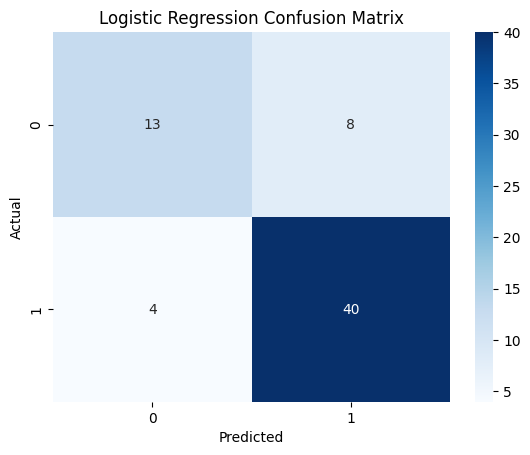


Decision Tree Metrics:
Accuracy: 0.8307692307692308
Precision: 0.8235294117647058
Recall: 0.9545454545454546
F1 Score: 0.8842105263157894


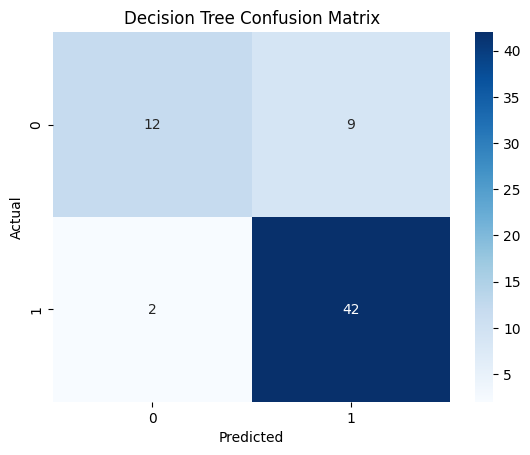


Random Forest Metrics:
Accuracy: 0.8
Precision: 0.7924528301886793
Recall: 0.9545454545454546
F1 Score: 0.865979381443299
ROC-AUC: 0.9047619047619047


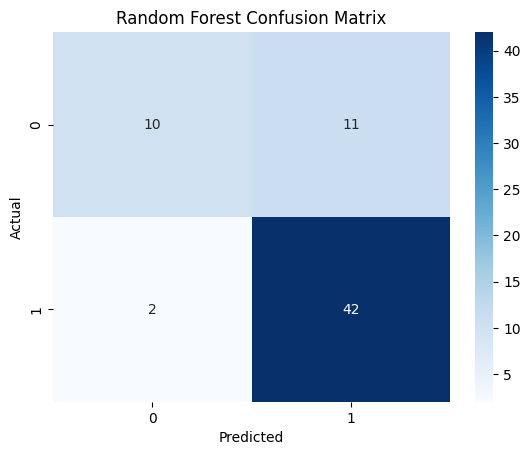


SVM Metrics:
Accuracy: 0.8461538461538461
Precision: 0.8695652173913043
Recall: 0.9090909090909091
F1 Score: 0.8888888888888888
ROC-AUC: 0.9231601731601732


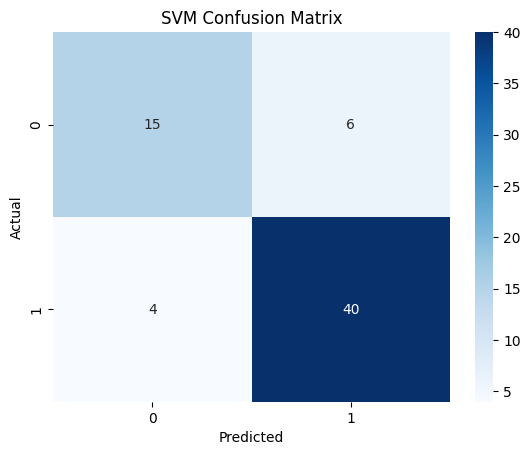

In [15]:
#Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# For binary classification, assuming positive class is 1.
def print_metrics(y_true, y_pred, model_name, y_pred_proba=None):
    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    if y_pred_proba is not None:
        # ROC-AUC requires probabilities for the positive class
        print("ROC-AUC:", roc_auc_score(y_true, y_pred_proba))
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Logistic Regression (Note: Use predict_proba for ROC-AUC)
print_metrics(y_test, y_pred_lr, "Logistic Regression", y_pred_proba=lr.predict_proba(X_test)[:, 1])
print_metrics(y_test, y_pred_dt, "Decision Tree")
print_metrics(y_test, y_pred_rf, "Random Forest", y_pred_proba=best_rf.predict_proba(X_test)[:, 1])
print_metrics(y_test, y_pred_svm, "SVM", y_pred_proba=best_svm.predict_proba(X_test)[:, 1])



Voting Classifier Metrics:
Accuracy: 0.8461538461538461
Precision: 0.8695652173913043
Recall: 0.9090909090909091
F1 Score: 0.8888888888888888


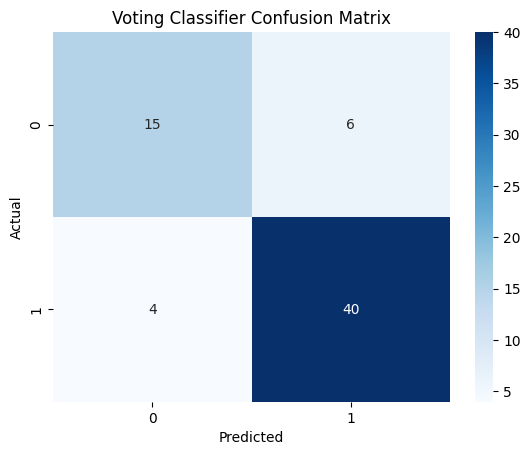

In [16]:
#Combine the four models using a VotingClassifier
from sklearn.ensemble import VotingClassifier

# Create a voting classifier. For soft voting, set voting='soft'
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('dt', best_dt),
        ('rf', best_rf),
        ('svm', best_svm)
    ],
    voting='hard'  # Change to 'soft' if you prefer probability averaging
)
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred_voting = voting_clf.predict(X_test)
# If soft voting is used, you can also get predict_proba for ROC-AUC.
print_metrics(y_test, y_pred_voting, "Voting Classifier")


In [17]:
#side by side model comparison
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Voting Classifier'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_voting)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_voting)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_voting)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_voting)
    ]
}

metrics_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(metrics_df)



Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.815385   0.833333  0.909091  0.869565
1        Decision Tree  0.830769   0.823529  0.954545  0.884211
2        Random Forest  0.800000   0.792453  0.954545  0.865979
3                  SVM  0.846154   0.869565  0.909091  0.888889
4    Voting Classifier  0.846154   0.869565  0.909091  0.888889


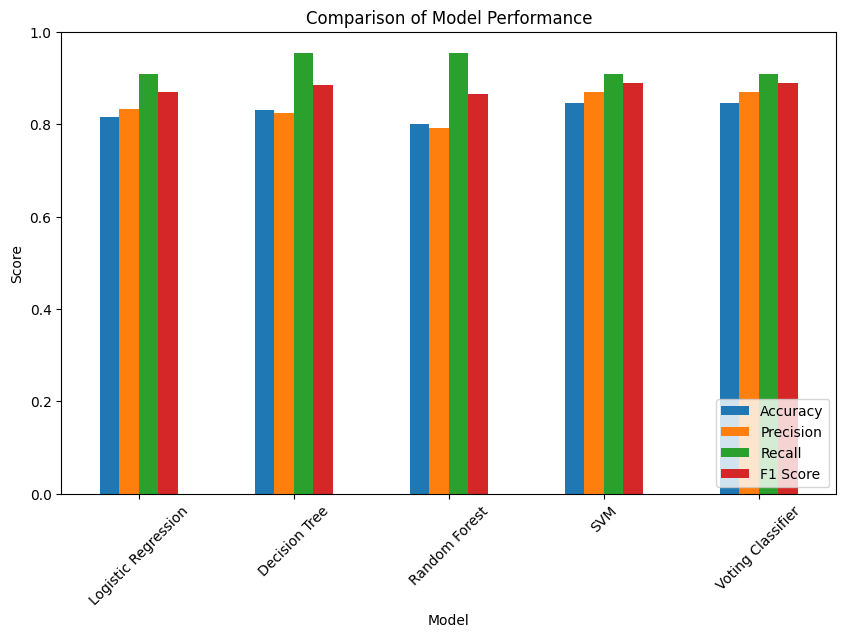

In [18]:
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of Model Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()
